In [60]:
from matplotlib import rcParams
rcParams["figure.dpi"] = 120
rcParams["savefig.dpi"] = 120

import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy import units as u

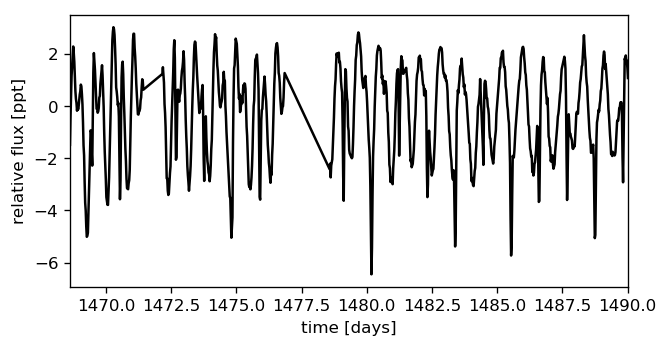

In [61]:
tess_file = 'tess_1359354.fits'#sys.argv[1]

with fits.open(tess_file) as tess_data:
    data = tess_data[1].data
    t = data["TIME"]
    y = data["SAP_FLUX"]
    q = data["QUALITY"]

# This is from the EVEREST source. These are the flagged data points
# that should be removed. Ref: https://github.com/rodluger/everest
m = np.isfinite(t) & np.isfinite(y)
for b in [1, 2, 3, 4, 5, 6, 7]:
    m &= (q & (2 ** (b - 1))) == 0

t = np.ascontiguousarray(t[m], dtype=np.float64) * u.day
y = np.ascontiguousarray(y[m], dtype=np.float64)
y = (y / np.median(y) - 1)*1e3

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 3))
ax.plot(t, y, "k")
ax.set_xlim(t.min().value, t.max().value)
ax.set_xlabel("time [days]")
ax.set_ylabel("relative flux [ppt]");

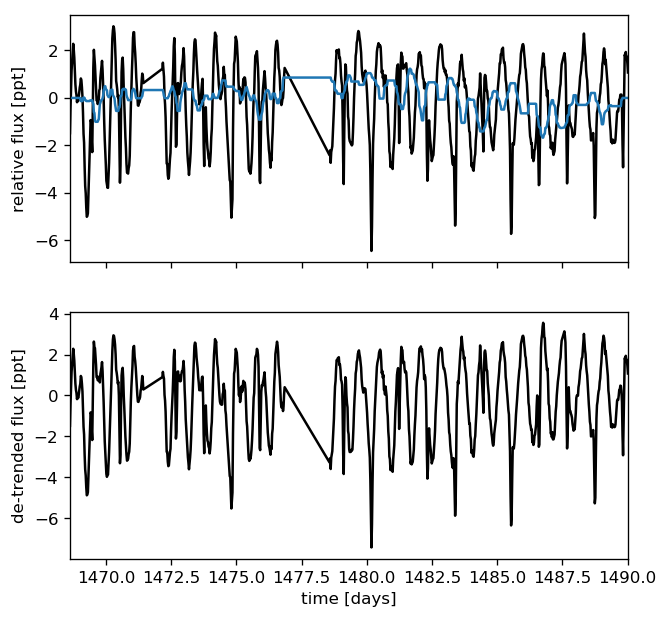

In [62]:
from scipy.signal import medfilt

trend = medfilt(y, 45)
mu = np.median(y)
y_filt =(y - trend)

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 6))
ax = axes[0]
ax.plot(t, y, "k")
ax.plot(t, trend)
ax.set_ylabel("relative flux [ppt]")

ax = axes[1]
ax.plot(t, y_filt, "k")
ax.set_xlim(t.min().value, t.max().value)
ax.set_xlabel("time [days]")
ax.set_ylabel("de-trended flux [ppt]");

In [68]:
from astropy.stats import BoxLeastSquares as BLS

#durations = np.linspace(6, 8, 100) * u.day
durations = 2.162 * u.h
model = BLS(t, y)
results = model.autopower(durations, frequency_factor=5.0)
print(results)

          depth: array([0.129205  , 0.14910393, 0.15453856, ..., 3.86854403, 3.86854403,
       3.80282227])
      depth_err: array([0.06711714, 0.06711833, 0.06711833, ..., 0.50112994, 0.50112994,
       0.37946306])
      depth_snr: array([ 1.92506723,  2.22150838,  2.30247919, ...,  7.71964252,
        7.71964252, 10.02158743])
       duration: <Quantity [0.09008333, 0.09008333, 0.09008333, ..., 0.09008333, 0.09008333,
           0.09008333] d>
 log_likelihood: array([ 3.73109395,  4.89103608,  5.25407641, ..., 29.93126581,
       29.93126581, 50.61510026])
      objective: 'likelihood'
         period: <Quantity [ 0.18016667,  0.18019863,  0.1802306 , ..., 10.4589232 ,
           10.56773093, 10.67882638] d>
          power: array([ 3.73109395,  4.89103608,  5.25407641, ..., 29.93126581,
       29.93126581, 50.61510026])
   transit_time: <Quantity [0.04620264, 0.16407255, 0.08373062, ..., 3.57850634, 9.26397888,
           1.15844563] d>


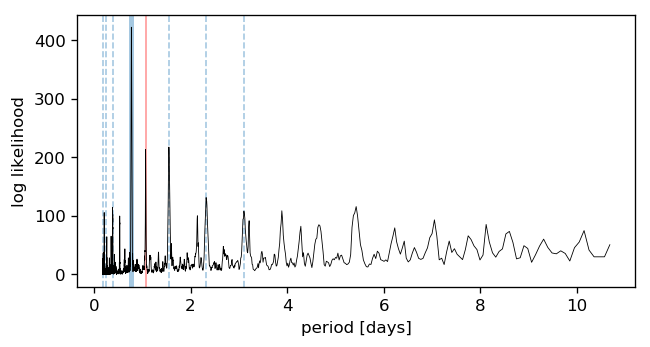

In [73]:
# Find the period of the peak
period = results.period[np.argmax(results.power)]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

# Highlight the harmonics of the peak period
ax.axvline(period.value, alpha=0.4, lw=3)
for n in range(2, 5):
    ax.axvline(n*period.value, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(period.value / n, alpha=0.4, lw=1, linestyle="dashed")
ax.axvline(1.071, alpha=0.4, c='r', lw=1, linestyle="solid")

# Plot the periodogram
ax.plot(results.period, results.power, "k", lw=0.5)

#ax.set_xlim(results.period.min().value, results.period.max().value)
ax.set_xlabel("period [days]")
ax.set_ylabel("log likelihood");

In [76]:
period = 1.071*u.d

In [77]:
index = np.argmax(results.power)
period = results.period[index]
t0 = results.transit_time[index]
duration = results.duration[index]

model.compute_stats(period, duration, t0)

{'transit_times': <Quantity [1469.30536931, 1470.0819032 , 1470.85843708, 1471.63497097,
            1472.41150485, 1473.18803874, 1473.96457263, 1474.74110651,
            1475.5176404 , 1476.29417429, 1477.07070817, 1477.84724206,
            1478.62377595, 1479.40030983, 1480.17684372, 1480.95337761,
            1481.72991149, 1482.50644538, 1483.28297926, 1484.05951315,
            1484.83604704, 1485.61258092, 1486.38911481, 1487.1656487 ,
            1487.94218258, 1488.71871647, 1489.49525036] d>,
 'per_transit_count': array([5, 5, 4, 0, 5, 4, 4, 2, 5, 4, 0, 0, 3, 3, 5, 4, 4, 4, 5, 4, 4, 5,
        5, 4, 4, 5, 4]),
 'per_transit_log_likelihood': array([44.63929713, 30.01176358, 19.24342754,  0.        , 24.93977529,
        18.24685173, 15.10700021, 12.25190173, 24.35461879, 14.67041659,
         0.        ,  0.        ,  8.95562649,  5.06256912, 47.48889724,
        17.06326715,  9.8180128 , 12.96958468, 16.25377775, 18.12016836,
         8.1151126 , 11.92293024, 15.39526096, 1

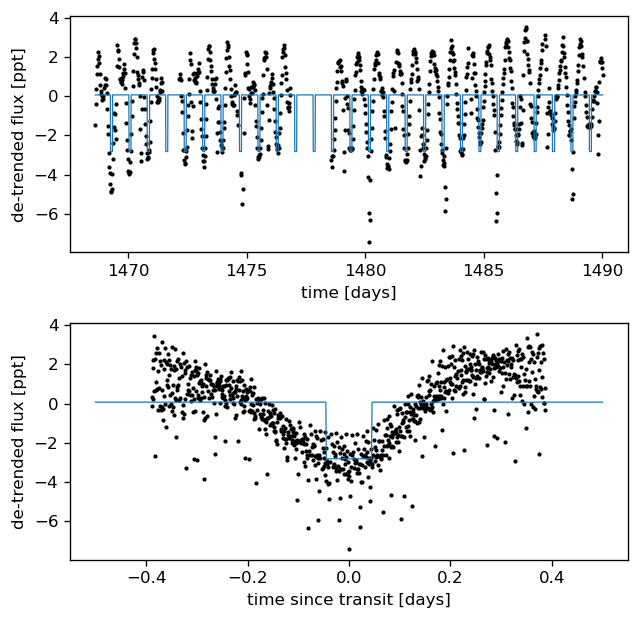

In [79]:
# Extract the parameters of the best-fit model
index = np.argmax(results.power)
period = results.period[index]
t0 = results.transit_time[index]
duration = results.duration[index]

fig, axes = plt.subplots(2, 1, figsize=(6, 6))
fig.subplots_adjust(hspace=0.3)

# Plot the light curve and best-fit model
ax = axes[0]
ax.plot(t, y_filt, ".k", ms=3)
x = np.linspace(t.min(), t.max(), 3*len(t))
f = model.model(x, period, duration, t0)
#ax.set_xlim(1481,1483)
#ax.set_xlim(1520,1525)
ax.plot(x, f, lw=0.75)
ax.set_xlabel("time [days]")
ax.set_ylabel("de-trended flux [ppt]");

# Plot the folded data points within 0.5 days of the transit time
ax = axes[1]
x = (t - t0 + 0.5*period) % period - 0.5*period
m = np.abs(x) < 0.5 * u.day
ax.plot(x[m], y_filt[m], ".k", ms=3)

# Over-plot the best fit model
x = np.linspace(-0.5, 0.5, 1000) * u.day
f = model.model(x + t0, period, duration, t0)
ax.plot(x, f, lw=0.75)
ax.set_xlabel("time since transit [days]")
ax.set_ylabel("de-trended flux [ppt]");

In [81]:
### Read in MASCARA data.
import h5py
import glob

mascara_data_LSS = glob.glob('*LSS*')#'red0_vmag_2018Q1LSS.hdf5'
mascara_data_LSC = glob.glob('*LSC*')#sys.argv[2]
mascara_data_LSE = glob.glob('*LSE*')
mascara_data_LSW = glob.glob('*LSW*')

In [86]:
def get_lightcurves(mascara_data, ascc):
    
    camera = []
    for i in range(len(mascara_data)):
        camera.append(h5py.File(mascara_data[i], 'r'))
        
    lc = []
    for i in range(len(camera)):
        lc.append(camera[i]['lightcurves'][ascc][()])
        
    # Remove points binned from <=45 points.
    mask = []
    for i in range(len(lc)):
        mask.append(lc[i]['nobs'] > 45)
        lc[i] = lc[i][mask[i]]

    # Convert lst sequence to lst index.
    lstidx = []
    for i in range(len(lc)):
        lstidx.append(lc[i]['lstseq'] % 270)
        
    return lc, lstidx

#lss_lc, lss_lstidx_season = get_lightcurves(mascara_data_LSS, '1359354')
lsc_lc, lsc_lstidx_season = get_lightcurves(mascara_data_LSC, '1359354')
#lse_lc, lse_lstidx_season = get_lightcurves(mascara_data_LSE, '1359354')
#lsw_lc, lsw_lstidx_season = get_lightcurves(mascara_data_LSW, '1359354')

In [87]:
def collect_data(lc, idx):
    jd = []
    for i in range(len(lc)):
        jd.append(lc[i]['jd'])
    
    index = []
    for i in range(len(idx)):
        index.append(idx[i])
    
    return np.concatenate(jd) , np.concatenate(index)

lsc_jd, lsc_lstidx = collect_data(lsc_lc, lsc_lstidx_season)

In [88]:
### Secondary data calibriation on MASCARA by Local linear method.

# Compute a moving mean along the x-axis.
def moving_mean(x, y, yerr=None, window=3.):
    
    # Set the weights.
    if yerr is None:
        weights = np.ones_like(y)
    else:
        weights = 1/yerr**2

    # Sums for computing the mean.
    sum1 = np.append(0, np.cumsum(weights*y))
    sum2 = np.append(0, np.cumsum(weights))
    
    # Indices at the start and end of the window.
    i = np.searchsorted(x, x - window/2.)
    j = np.searchsorted(x, x + window/2.)
    
    # Compute the mean.
    mean = (sum1[j] - sum1[i])/(sum2[j] - sum2[i])
    
    return mean

# Fit a curve for local linear
def linfit(lstidx, x, y, sky, mag, emag):
    
    sort = np.argsort(lstidx)
    invsort = np.argsort(sort)
    
    lstidx = lstidx[sort]
    x = x[sort]
    y = y[sort]
    sky = sky[sort]
    mag = mag[sort]
    emag = emag[sort]

    _, idx = np.unique(lstidx, return_inverse=True)

    nobs = np.bincount(idx)
    strides = np.append(0, np.cumsum(nobs))

    xbar = np.bincount(idx, x)/np.bincount(idx)
    ybar = np.bincount(idx, y)/np.bincount(idx)

    mat = np.column_stack([np.ones(len(lstidx)), x-xbar[idx], y-ybar[idx], sky])

    pars = np.zeros((len(nobs), 4))
    pars[:,0] = np.bincount(idx, mag/emag**2)/np.bincount(idx, 1/emag**2)

    for i in range(len(nobs)):

        if nobs[i] < 5:
             continue

        i1 = strides[i]
        i2 = strides[i+1]

        pars[i] = np.linalg.lstsq(mat[i1:i2]/emag[i1:i2,None], mag[i1:i2]/emag[i1:i2], rcond=None)[0]

    fit = np.sum(pars[idx]*mat, axis=1)

    fit1 = pars[idx,0]
    fit2 = fit - pars[idx,0]

    return fit1[invsort], fit2[invsort], (nobs > 4)[idx][invsort]

def local_lin(jd, lstseq, x, y, sky, mag, emag, window=5., maxiter=50, dtol=1e-3):
     
    lstidx = (lstseq % 270)
    fit0 = np.zeros(len(jd))
    fit1 = np.zeros(len(jd))

    fit = np.zeros_like(mag)
    for niter in range(maxiter):
        fit1, fit2, mask = linfit(lstidx, x, y, sky, mag - fit0, emag)
        fit0 = moving_mean(jd, mag - fit1 - fit2, emag, window)

        if niter > 0:

            if np.all(np.abs(fit - fit0 - fit1 - fit2) < dtol):
                break

        fit = fit0 + fit1 + fit2

    return fit#, fit0, fit1, fit2, mask

In [89]:
def sec_cali(lc):
    
    vmag = []
    for i in range(len(lc)):
        vmag.append(lc[i]['mag0'] - local_lin(lc[i]['jd'],
                                              lc[i]['lstseq'],
                                              lc[i]['x'],
                                              lc[i]['y'],
                                              lc[i]['sky'],
                                              lc[i]['mag0'],
                                              lc[i]['emag0']))
    
    return np.concatenate([vmag[0], vmag[1], vmag[2], vmag[3]])*(-1)

lsc_mag = sec_cali(lsc_lc)

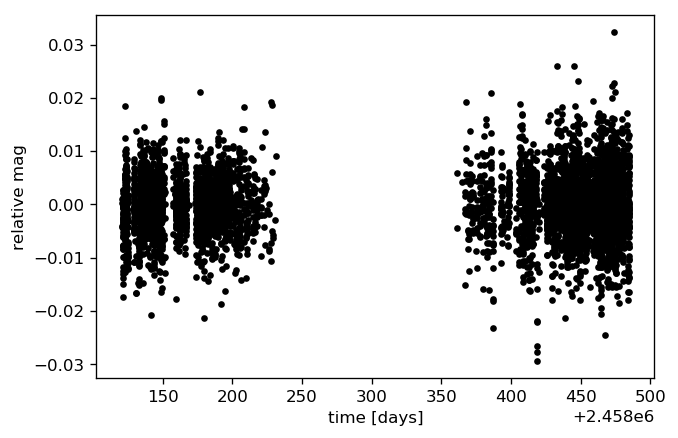

In [91]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 4))
ax.plot(lsc_jd*u.d, lsc_mag, ".k")
#ax.set_xlim(lss_jd.min().value, lss_jd.max().value)
ax.set_xlabel("time [days]")
ax.set_ylabel("relative mag");

#plt.plot(lsc_jd, trend)
#plt.gca().invert_yaxis()

In [92]:
from astropy.stats import BoxLeastSquares as BLS

durations = 2.162 * u.h
model = BLS(lsc_jd*u.d, lsc_mag)
results = model.autopower(durations, frequency_factor=5.0)
print(results)

          depth: array([0.00047606, 0.00056869, 0.00057431, ..., 0.02083659, 0.02083659,
       0.02083659])
      depth_err: array([0.02814114, 0.02814146, 0.02814146, ..., 0.35383371, 0.35383371,
       0.35383371])
      depth_snr: array([0.01691701, 0.02020825, 0.02040798, ..., 0.05888809, 0.05888809,
       0.05888809])
       duration: <Quantity [0.09008333, 0.09008333, 0.09008333, ..., 0.09008333, 0.09008333,
           0.09008333] d>
 log_likelihood: array([0.00028658, 0.0004104 , 0.00041856, ..., 0.00173665, 0.00173665,
       0.00173665])
      objective: 'likelihood'
         period: <Quantity [1.80166667e-01, 1.80166777e-01, 1.80166887e-01, ...,
           1.81815938e+02, 1.81928291e+02, 1.82040782e+02] d>
          power: array([0.00028658, 0.0004104 , 0.00041856, ..., 0.00173665, 0.00173665,
       0.00173665])
   transit_time: <Quantity [8.00909695e-02, 2.61523529e-02, 1.43372213e-01, ...,
           8.54480496e+01, 2.17585191e+01, 1.40022134e+02] d>


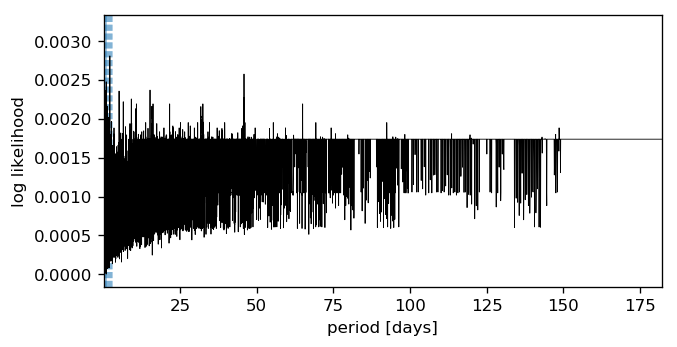

In [93]:
# Find the period of the peak
period = results.period[np.argmax(results.power)]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

# Highlight the harmonics of the peak period
ax.axvline(period.value, alpha=0.4, lw=3)
for n in range(2, 10):
    ax.axvline(n*period.value, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(period.value / n, alpha=0.4, lw=1, linestyle="dashed")

# Plot the periodogram
ax.plot(results.period, results.power, "k", lw=0.5)

ax.set_xlim(results.period.min().value, results.period.max().value)
ax.set_xlabel("period [days]")
ax.set_ylabel("log likelihood");

In [94]:
period

<Quantity 0.30382322 d>

In [95]:
index = np.argmax(results.power)
period = results.period[index]
t0 = results.transit_time[index]
duration = results.duration[index]

model.compute_stats(period, duration, t0)

{'transit_times': <Quantity [2458121.67273563, 2458121.97655885, 2458122.28038207, ...,
            2458484.13383762, 2458484.43766084, 2458484.74148406] d>,
 'per_transit_count': array([24,  0,  0, ...,  0,  0, 19]),
 'per_transit_log_likelihood': array([0.00015634, 0.        , 0.        , ..., 0.        , 0.        ,
        0.00025684]),
 'depth': (0.002117883443211936, 0.03132599324765169),
 'depth_phased': (-0.0007769163476006279, 0.03349469931196398),
 'depth_half': (0.000438742564588112, 0.028612421842269413),
 'depth_odd': (0.0022984405499909587, 0.04051201528269875),
 'depth_even': (0.0019246556622729812, 0.04167842928638206),
 'harmonic_amplitude': 0.0013934393652058445,
 'harmonic_delta_log_likelihood': 0.00016488881340380457}

NameError: name 'mascara_jd' is not defined

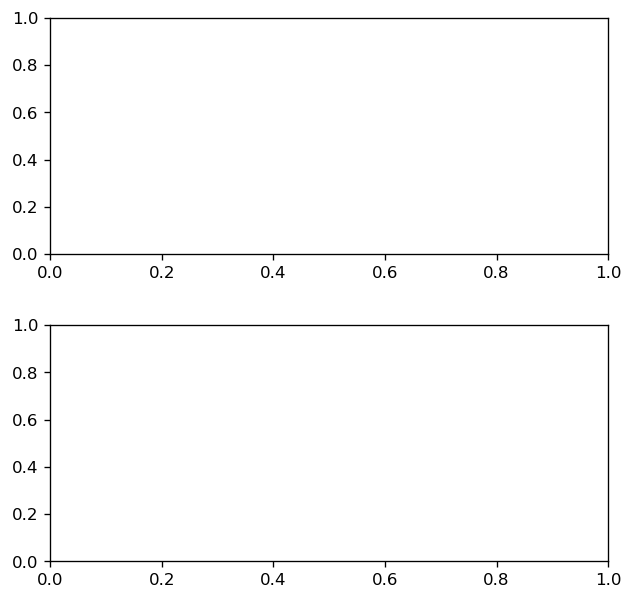

In [96]:
# Extract the parameters of the best-fit model

fig, axes = plt.subplots(2, 1, figsize=(6, 6))
fig.subplots_adjust(hspace=0.3)
#period = period*4
# Plot the light curve and best-fit model
ax = axes[0]
ax.plot(mascara_jd, mascara_mag, ".k", ms=3)
bls_x = np.linspace(mascara_jd.min(), mascara_jd.max(), 3*len(mascara_jd))
bls_box = model.model(bls_x, period, duration, t0)
ax.plot(bls_x, bls_box, lw=0.75)
ax.set_xlim(mascara_jd.min().value, mascara_jd.max().value)
#ax.set_ylim(-1.52, 0.4)
ax.set_xlabel("time [days]")
ax.set_ylabel("relative magnitude");


# Plot the folded data points within 0.5 days of the transit time
ax = axes[1]
T0 = 2457000
epoch = 1471.925+T0

mascara_phase = (mascara_jd.value - epoch)/39.5#period.value
mascara_phase = np.mod(mascara_phase, 1)-.5
x = ((mascara_jd - t0 + 0.5*period) % period)/period - 0.5
#m = np.abs(x) < 0.5 * u.day
#ax.plot(x[m], y_filt[m], ".k", ms=3)
ax.plot(mascara_phase, mascara_mag, '.k', ms=3, alpha=0.2)


### Bin MASCARA data points.

#period = 39.500272* u.d

def spec_digitize_mean(x,y,numbins):
    mybins = np.linspace(min(x),max(x),numbins)
    digitized = np.digitize(x,mybins)
    xmeans = [np.nanmean(x[digitized==i]) for i in range(1,len(mybins))]
    ymeans= [np.nanmean(x[digitized==i]) for i in range(1,len(mybins))]
    return xmeans,ymeans

def spec_digitize_median(x,y,numbins):
    mybins = np.linspace(min(x),max(x),numbins)
    digitized = np.digitize(x,mybins)
    xmedians = [np.nanmedian(x[digitized==i]) for i in range(1,len(mybins))]
    ymedians = [np.nanmedian(y[digitized==i]) for i in range(1,len(mybins))]
    return xmedians,ymedians

bins = spec_digitize_median(mascara_phase, mascara_mag, 6000)

binned_mascara_phase,binned_mascara_flux = np.asarray(bins)[0],np.asarray(bins)[1]

# Over-plot the best fit model
x = np.linspace(-0.5, 0.5, 10000) * u.day
f = model.model(x, period/period*u.day, 0.25*u.day, 0.00000001*u.day)
ax.plot(binned_mascara_phase, binned_mascara_flux, '.r')
#ax.plot(x, f, c='black', lw=1.5)
ax.set_xlim(-0.05, 0.05)
ax.set_xlabel("time since transit [days]")
ax.hlines(-0.006,-0.5,0.5)
ax.set_ylabel("relative magnitude");

[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]


Text(0, 0.5, 'Relative Intensity')

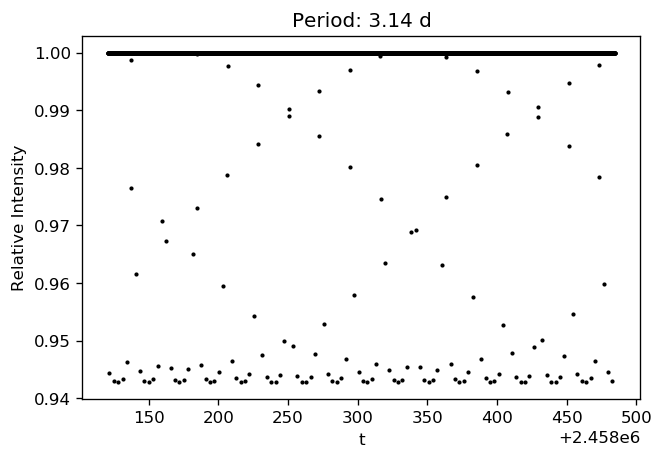

In [132]:
import batman #Bad-Ass Transit Model cAlculatioN
import astropy.units as u
from astropy.constants import G, R_sun, M_sun, R_jup, M_jup, R_earth, M_earth

params = batman.TransitParams() # object to store the transit parameters
params.t0 = 1.0 # time of inferior conjunction 
params.per = 3.14 # orbital period (days)
params.rp = R_earth*25/R_sun # planet radius (in units of stellar radii)

# calculate semi-major axis from orbital period value
a = (((params.per*u.day)**2 * G * (M_sun + M_earth) / (4*np.pi**2))**(1./3)).to(R_sun).value 

params.a = a # semi-major axis (in units of stellar radii)
params.inc = 90.0  # orbital inclination (in degrees)
params.ecc = 0. # eccentricity
params.w = 90. # longitude of periastron (in degrees), 90 for circular
params.u = [0.1, 0.3] # limb darkening coefficients
params.limb_dark = "quadratic" # limb darkening model

t = np.linspace(min(lsc_jd), max(lsc_jd), 3000) # times at which to calculate the light curve
m = batman.TransitModel(params, t) # initializes the model
f = m.light_curve(params)
print(f)

# add gaussian error 
rs = np.random.RandomState(seed=13)

errors = 0.007*np.ones_like(f) # if comparable to the depth of the transit
#f += errors*rs.randn(len(t))-1
print (f)

#plt.plot(lsc_jd, lsc_mag, '.k', ms=3)
plt.plot(t, f, '.k', ms=3)
plt.title("Period: {0} d".format(params.per))
plt.xlabel("t")
plt.ylabel("Relative Intensity")

In [133]:
(params.rp)**2

<Quantity 0.05253136>

In [134]:
T0 = 2458000
tau=1.3228e-8
#for i in range(len(tess_time)):
#    tess_time[i] = (tess_time[i]+T0)-i*tau
    
P = 3.14 # Days
#epoch = T0+1322.0828
#epoch = 1332.0828+T0 # BTJD

#P = 18.361 # Days
#epoch=1385.776+T0 # BTJD

#tess_phase=((tess_time-epoch)%P)
#tess_phase = np.array([tess_phase[i]/P if tess_phase[i] < P/2. 
#                       else (tess_phase[i]-P)/P for i in range(len(tess_phase))])

#tess_phase = (tess_time - epoch)/P
#tess_phase = np.mod(tess_phase+.5, 1)-.5

phase = (t - T0)/P
phase = np.mod(phase+.5, 1)-.5

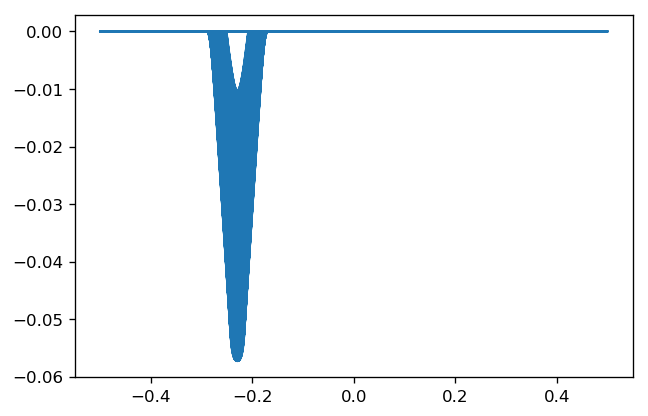

In [136]:
plt.plot(phase, f-1)